# Estudo Comparativo de Modelos de Séries Temporais Nebulosas

[<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">](https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode)


### Programa de Pós Graduação em Engenharia Elétrica - PPGEE
### Disciplina de Sistemas Nebulosos

Professor: André Paim Lemos

Autores: Leonardo Ferreira (leauferreira@gmail.com) e Petrônio Silva (petronio.candido@gmail.com)

* [Revisão De Literatura](https://www.overleaf.com/read/rqqctmpzgsnt)
* [Apresentação](https://www.overleaf.com/read/tdwskgrscknv)


## Índice

1. [Importações Comuns](#Importações-Comuns)
2. [Dados de Treinamento e Validação](#Dados-de-Treinamento-e-Validação)
   1. [University Of Alabama Enrollments](#University-Of-Alabama-Enrollments)
   2. [TAIEX - Taiwan Stock Exchange Index](#TAIEX---Taiwan-Stock-Exchange-Index)
3. [Códigos Comuns](#Códigos-Comuns)
   1. [Funções de Pertinência](#Funções-de-Pertinência)
   2. [Conjuntos Nebulosos](#Conjuntos-Nebulosos)
   3. [Particionadores do Universo de Discurso](#Particionadores-do-Universo-de-Discurso)
2. [First Order Fuzzy Time Series](#First-Order-Fuzzy-Time-Series)
   1. [FTS - Código Fonte](#FTS---Código-Fonte)
   2. [FTS - Experimento com o dataset Enrollments](#FTS---Experimento-com-o-dataset-Enrollments)
   3. [FTS - Experimento com o dataset TAIEX](#FTS---Experimento-com-o-dataset-TAIEX)
3. [Weighted Fuzzy Time Series](#Weighted-Fuzzy-Time-Series)
   1. [WFTS - Código Fonte](#WFTS---Código-Fonte)
   2. [WFTS - Experimento com o dataset Enrollments](#WFTS---Experimento-com-o-dataset-Enrollments)
   3. [WFTS - Experimento com o dataset TAIEX](#WFTS---Experimento-com-o-dataset-TAIEX)
4. [Improved Weighted Fuzzy Time Series](#Improved-Weighted-Fuzzy-Time-Series)
   1. [IWFTS - Código Fonte](#IWFTS---Código-Fonte)
   2. [IWFTS - Experimento com o dataset Enrollments](#IWFTS---Experimento-com-o-dataset-Enrollments)
   3. [IWFTS - Experimento com o dataset TAIEX](#IWFTS---Experimento-com-o-dataset-TAIEX)
5. [Exponentially Weighted Fuzzy Time Series](#Exponentially-Weighted-Fuzzy-Time-Series)
   1. [EWFTS - Código Fonte](#EWFTS---Código-Fonte)
   2. [EWFTS - Experimento com o dataset Enrollments](#EWFTS---Experimento-com-o-dataset-Enrollments)
   3. [EWFTS - Experimento com o dataset TAIEX](#EWFTS---Experimento-com-o-dataset-TAIEX)
6. [High Order Fuzzy Time Series](#High-Order-Fuzzy-Time-Series)
7. [Comparação entre os modelos]()
8. [Referências](#References)

# Importações Comuns

In [4]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Dados de Treinamento e Validação

### University Of Alabama Enrollments

O dataset abaixo foi retirado do artigo \cite{song1993fuzzy}

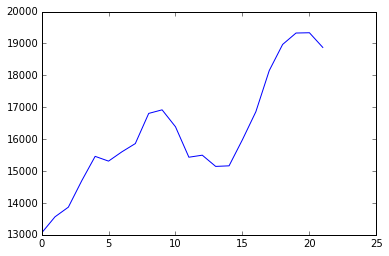

In [5]:
enrollments = pd.read_csv("DataSets/Enrollments.csv", sep=";")

plot(enrollments["Enrollments"])

### TAIEX - Taiwan Stock Exchange Index

O dataset foi provido por \cite{taiex2015}

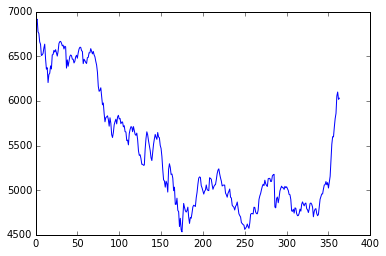

In [6]:
taiex = pd.read_csv("DataSets/TAIEX.csv", sep=",")
taiexsample = taiex["avg"][1:365]
plot(taiexsample)

# Códigos Comuns

### Funções de Pertinência

In [7]:
def trimf(x,parameters):
	if(x < parameters[0]):
		return 0
	elif(x >= parameters[0] and x < parameters[1]):
		return (x-parameters[0])/(parameters[1]-parameters[0])
	elif(x >= parameters[1] and x <= parameters[2]):
		return (parameters[2]-x)/(parameters[2]-parameters[1])
	else: 
		return 0

def trapmf(x, parameters):
		if(x < parameters[0]):
			return 0
		elif(x >= parameters[0] and x < parameters[1]):
			return (x-parameters[0])/(parameters[1]-parameters[0])
		elif(x >= parameters[1] and x <= parameters[2]):
			return 1
		elif(x >= parameters[2] and x <= parameters[3]):
			return (parameters[3]-x)/(parameters[3]-parameters[2])
		else: 
			return 0

def gaussmf(x,parameters):
		return math.exp(-0.5*((x-parameters[0]) / parameters[1] )**2)


def bellmf(x,parameters):
		return 1 / (1 + abs((xx - parameters[2])/parameters[0])**(2*parameters[1]))


def sigmf(x,parameters):
		return 1 / (1 + math.exp(-parameters[0] * (x - parameters[1])))


### Conjuntos Nebulosos

In [8]:
class FuzzySet:

	def __init__(self,name,mf,parameters,centroid):
		self.name = name
		self.mf = mf
		self.parameters = parameters
		self.centroid = centroid
        
	def membership(self,x):
		return self.mf(x,self.parameters)
    
	def __str__(self):
		return self.name + ": " + str(self.mf) + "(" + str(self.parameters) + ")"
    
    

### Particionadores do Universo de Discurso

In [9]:
def GridPartitionerTrimf(data,npart,names = None,prefix = "A"):
	sets = []
	dmax = max(data)
	dmin = min(data)
	dlen = dmax - dmin
	partlen = dlen / npart
	partition = dmin
	for c in range(npart):
		sets.append( FuzzySet(prefix+str(c),trimf,[partition-partlen, partition, partition+partlen], partition ) )
		partition = partition + partlen
		
	return sets

In [ ]:
sts = GridPartitionerTrimf(enrollments["Enrollments"],10)
for s in sts:
    print(s)

In [107]:
class FTS:
	def __init__(self,order,name):
		self.sets = {}
		self.flrgs = {}
		self.order = order
		self.name = name
        
	def fuzzy(self,data):
		best = {"fuzzyset":"", "membership":0.0}

		for f in self.sets:
			fset = self.sets[f]
			if best["membership"] <= fset.membership(data):
				best["fuzzyset"] = fset.name
				best["membership"] = fset.membership(data)

		return best

	def defuzzy(self,data):
		pass
        
	def learn(self, data, sets):
		pass  

	def predict(self,data):
		return self.defuzzy(data)
    
	def plot(self,original):
		fig = plt.figure(figsize=[20,6])
		predicted = [self.predict(xx) for xx in original]
		error = rmse(original,predicted)
		plot(original,color='b',label="Original")
		plot(predicted,color='r',label="Predicted")
		#handles0, labels0 = plt.get_legend_handles_labels()
		#plt.legend(handles0, labels0)
		ret = []
		ret.append(predicted)
		ret.append(error)
		return ret
    
	def __str__(self):
		tmp = self.name + ":\n"
		for r in self.flrgs.keys():
			tmp = tmp + str(self.flrgs[r]) + "\n"
		return tmp


### Funções Auxiliares

In [108]:
def rmse(predictions,targets):
    return np.sqrt(np.mean((predictions-targets)**2))
    

In [109]:
def SelecaoSimples_MenorRMSE(original,parameters,modelo):
	errors = []
	fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
	fig.suptitle("Comparação de modelos ")
	fig.set_size_inches(18, 10)
	ax0 = axs[0]
	ax0.set_title('Série Temporal')
	ax0.set_ylabel('F(T)')
	ax0.set_xlabel('T')
	ax0.plot(original,label="Original")
	min_rmse = 100000.0
	best = None
	for p in parameters:
		sets = GridPartitionerTrimf(original,p)
		fts = modelo(str(p)+ " particoes")
		fts.learn(original,sets)
		predicted = [fts.predict(xx) for xx in original]
		ax0.plot(predicted,label=fts.name)
		error = rmse(np.array(predicted),np.array(original))
		print(p,error)
		errors.append(error)
		if error < min_rmse:
			min_rmse = error
			best = fts
	handles0, labels0 = ax0.get_legend_handles_labels()
	ax0.legend(handles0, labels0)
	ax1 = axs[1]
	ax1.set_title('Comparação dos Erros Quadráticos Médios')
	ax1.set_ylabel('RMSE')
	ax1.set_xlabel('Quantidade de Partições')
	ax1.set_xlim([min(parameters),max(parameters)])
	ax1.plot(parameters,errors)
	return best

# First Order Fuzzy Time Series

Os trabalhos pioneiros em séries temporais nebulosas são de \cite{song1993fuzzy} e a evolução apresentada por \cite{chen1996forecasting}. Nesses trabalhos define-se que o modelo de primeira ordem (\textit{First Order Fuzzy Time Series}) caracteriza-se por presumir que $F(t)$ é determinado unicamente por $F(t-1)$ ( ou $F(t-2)$ ou ... ou $F(t-m)$ ).

## FTS - Código Fonte

In [110]:
class FirstOrderFLRG:
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = set()
	
	def append(self,c):
		self.consequent.add(c)

	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c
		return tmp + tmp2


In [111]:
class FirstOrderFTS(FTS):
	def __init__(self,name):
		super(FirstOrderFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		count = 0.0
		denom = 0.0

		for s in flrg.consequent:
			denom = denom + self.sets[s].centroid
			count = count + 1.0

		return denom/count
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = FirstOrderFLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual
        

## FTS - Experimento com o dataset Enrollments

8 1210.89818045
10 435.391975956
20 521.825771059
30 504.555710502


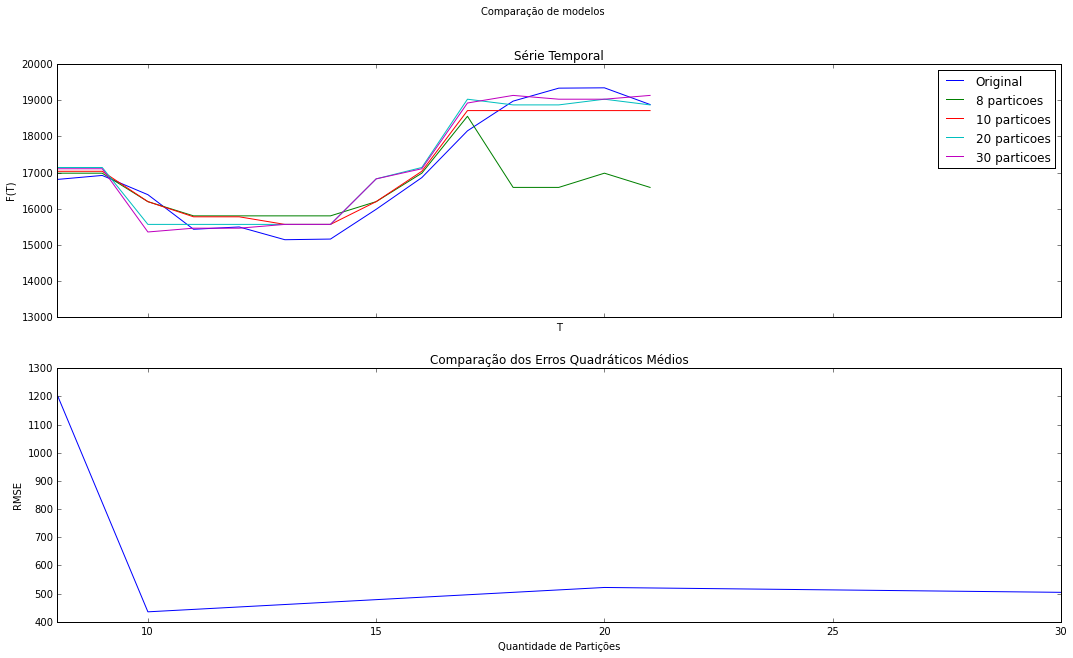

In [112]:
fts1 = SelecaoSimples_MenorRMSE(enrollments["Enrollments"],[8, 10,20, 30],FirstOrderFTS)

In [113]:
print(fts1)

10 particoes:
A5 -> A4,A6
A1 -> A1,A3
A0 -> A1
A9 -> A9
A3 -> A4,A5,A3
A4 -> A4,A6,A3
A8 -> A9
A6 -> A5,A8,A6



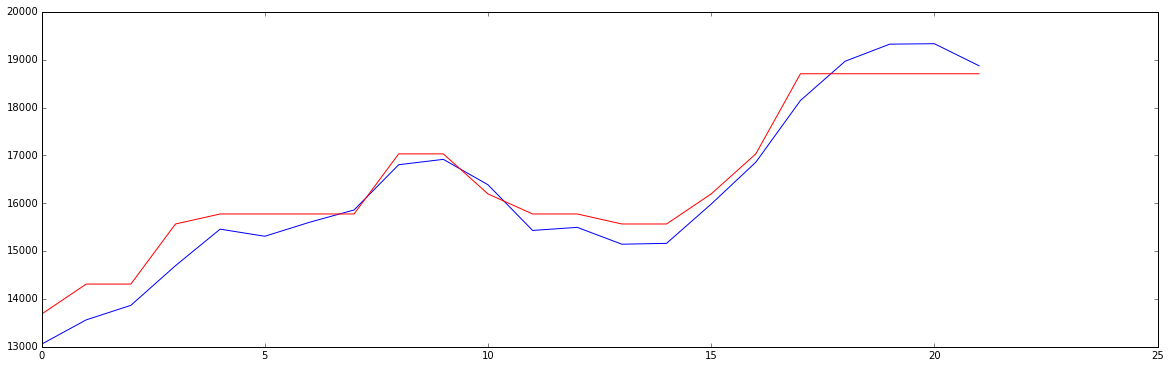

In [114]:
fts1p = fts1.plot(enrollments["Enrollments"])

## FTS - Experimento com o dataset TAIEX

10 76.2322839423
15 220.511145937
20 64.1396258604
25 47.2639320704
30 65.1506895139
35 85.6378889274


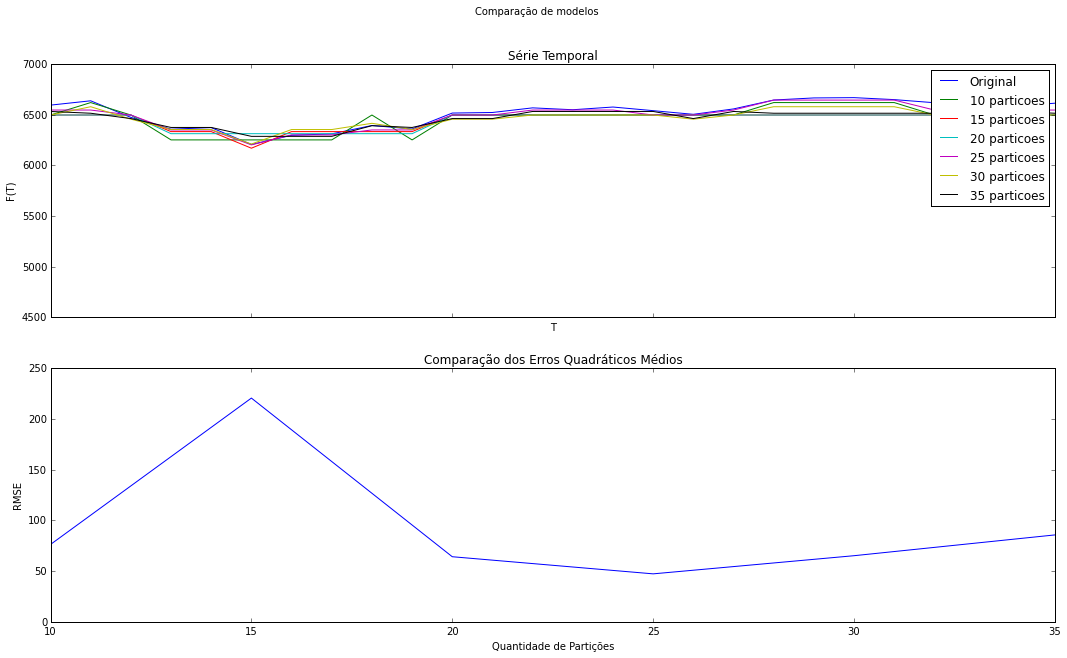

In [115]:
fts2= SelecaoSimples_MenorRMSE(taiexsample,[10,15,20,25,30,35],FirstOrderFTS)

In [116]:
print(fts2)

25 particoes:
A19 -> A19,A17,A20,A18
A11 -> A11,A10,A12,A9
A1 -> A1,A0,A2
A16 -> A15,A16
A20 -> A20,A19,A21
A13 -> A13,A12,A14
A6 -> A5,A8,A6,A7
A24 -> A24,A23
A23 -> A23,A22
A3 -> A4,A3,A2
A5 -> A5,A4,A6,A7,A3
A10 -> A11,A10,A9
A15 -> A15,A13
A2 -> A4,A1,A0,A3,A2
A21 -> A20,A19,A22,A21
A17 -> A16,A18
A22 -> A22,A21
A0 -> A1,A0,A2
A12 -> A11,A13,A12
A4 -> A5,A4,A3,A2
A8 -> A8,A10,A7,A9
A7 -> A8,A6,A7,A3
A14 -> A16
A9 -> A11,A8,A10,A7,A9
A18 -> A19,A17,A18



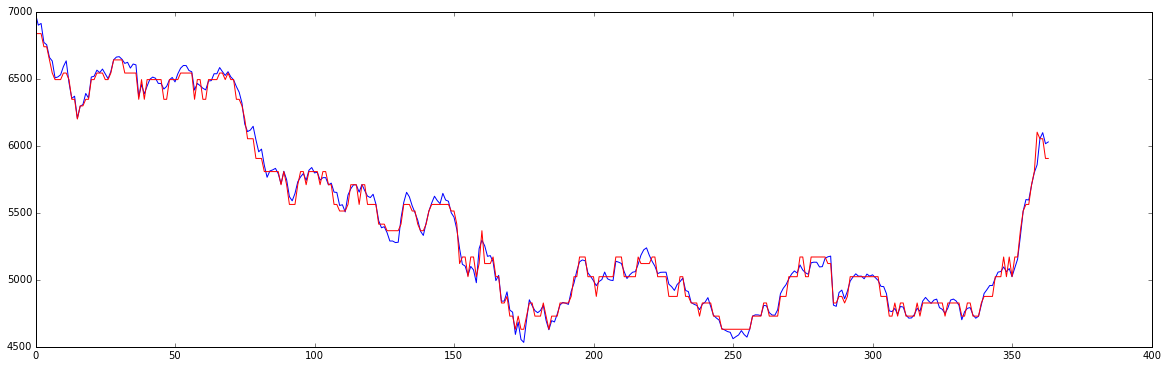

In [117]:
fts2p = fts2.plot(taiexsample)

# Weighted Fuzzy Time Series

O trabalho de \cite{yu2005weighted} propõe um modelo  - as \textit{Weighted Fuzzy Time Series} -  em que os grupos de regras permitem repetições no consequente e tenham ponderação monotonicamente crescente, baseado na ordem cronológica dos termos no consequente. Nesse modelo as FLRG's permitem a repetição de conjuntos no consequente das regras, e os conjuntos devem ser apresentados em ordem cronológica.


## WFTS - Código Fonte

In [118]:
class WeightedFLRG(FTS):
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = []
		self.count = 1.0

	def append(self,c):
		self.consequent.append(c)
		self.count = self.count + 1.0

	def weights(self):
		tot = sum( np.arange(1.0,self.count,1.0) )
		return np.array([ k/tot for k in np.arange(1.0,self.count,1.0) ])
        
	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		cc = 1.0
		tot = sum( np.arange(1.0,self.count,1.0) )
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c + "(" + str(cc/tot) + ")"
			cc = cc + 1.0
		return tmp + tmp2

In [119]:
class WeightedFTS(FTS):
	def __init__(self,name):
		super(WeightedFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		mi = np.array([self.sets[s].centroid for s in flrg.consequent])
        
		return mi.dot( flrg.weights() )
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = WeightedFLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual


## WFTS - Experimento com o dataset Enrollments

6 1323.44786259
8 1413.67949023
10 489.718215586
12 1576.40634363
14 523.447886773


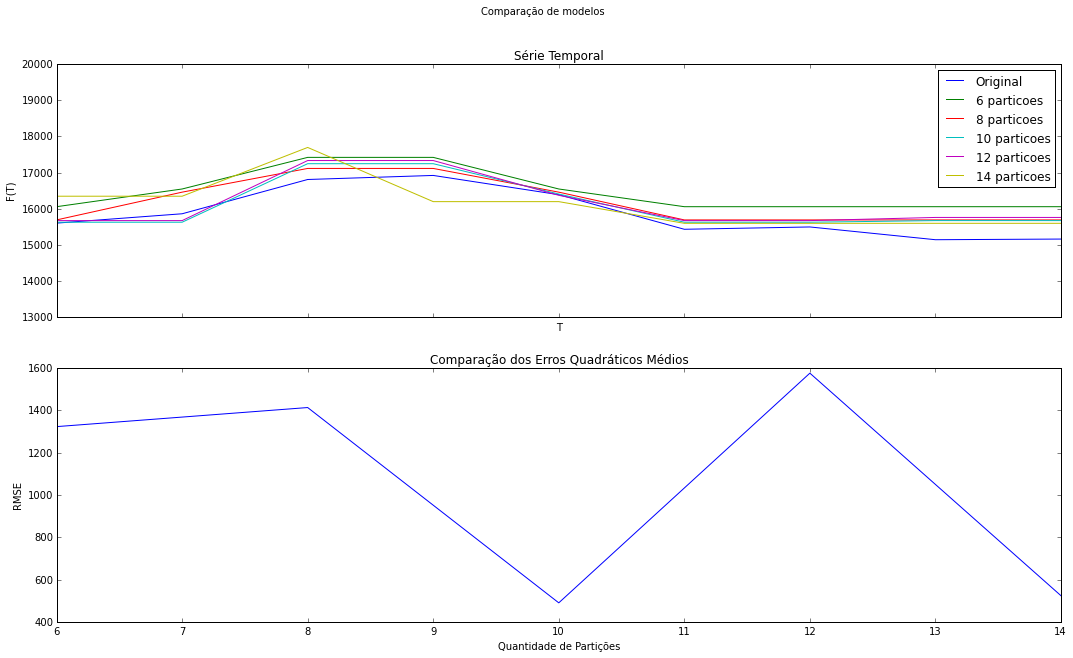

In [120]:
wfts1 = SelecaoSimples_MenorRMSE(enrollments["Enrollments"],[6,8,10,12,14], WeightedFTS)

In [121]:
print(wfts1)

10 particoes:
A5 -> A4(0.333333333333),A6(0.666666666667)
A1 -> A1(0.333333333333),A3(0.666666666667)
A0 -> A1(1.0)
A9 -> A9(0.166666666667),A9(0.333333333333),A9(0.5)
A3 -> A4(0.166666666667),A3(0.333333333333),A5(0.5)
A4 -> A4(0.047619047619),A4(0.0952380952381),A4(0.142857142857),A6(0.190476190476),A4(0.238095238095),A3(0.285714285714)
A8 -> A9(1.0)
A6 -> A6(0.166666666667),A5(0.333333333333),A8(0.5)



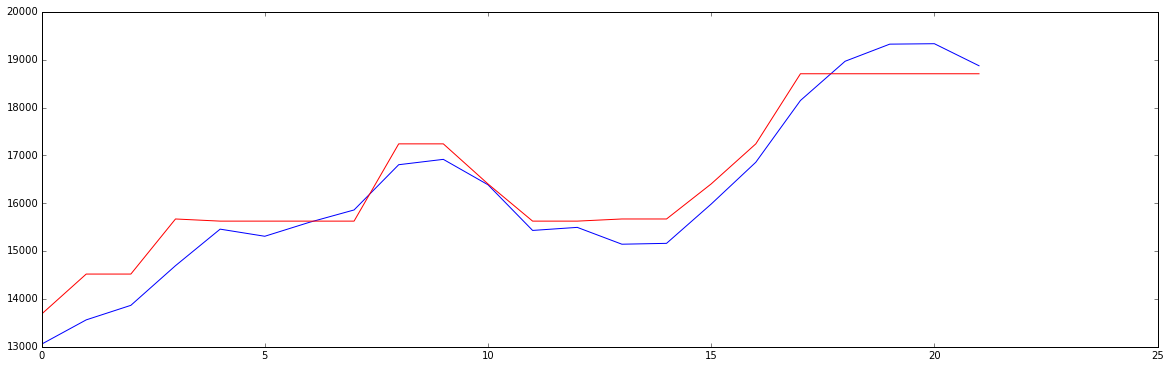

In [122]:
#fts.predict(15000)
wfts1p = wfts1.plot(enrollments["Enrollments"])

## WFTS - Experimento com o dataset TAIEX

10 70.7217498116
15 121.812396436
20 40.7743964487
25 39.8003416364
30 56.9955795547
35 71.7731028669


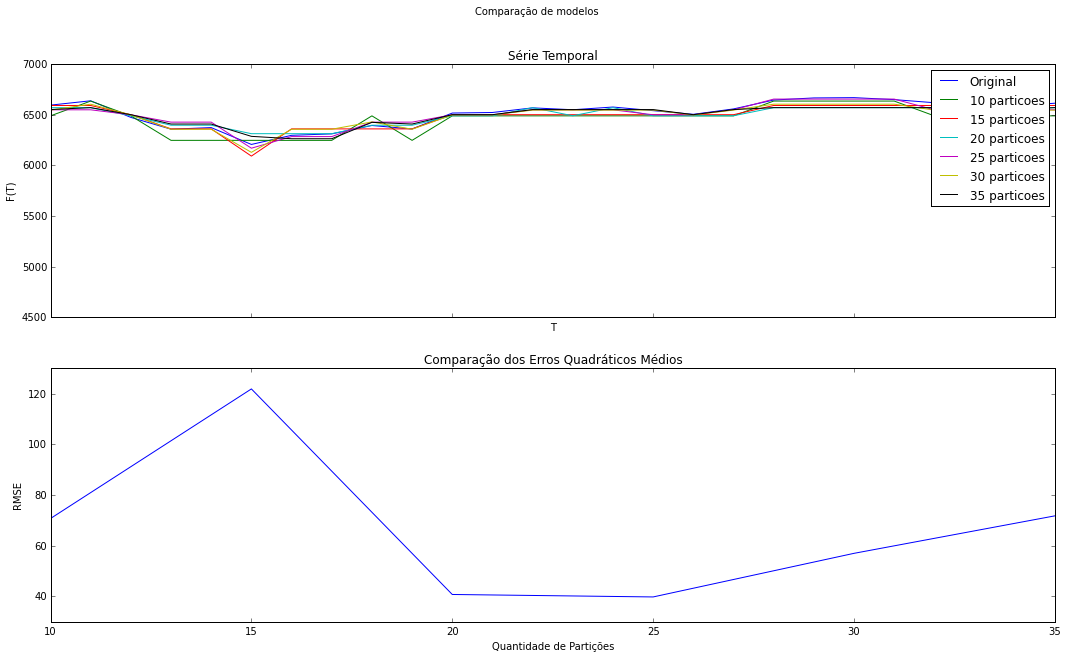

In [137]:
wfts2 = SelecaoSimples_MenorRMSE(taiexsample,[10,15,20,25,30,35], WeightedFTS)

In [138]:
print(wfts2)

25 particoes:
A19 -> A19(0.010989010989),A17(0.021978021978),A19(0.032967032967),A20(0.043956043956),A20(0.0549450549451),A20(0.0659340659341),A19(0.0769230769231),A20(0.0879120879121),A20(0.0989010989011),A19(0.10989010989),A20(0.120879120879),A19(0.131868131868),A18(0.142857142857)
A11 -> A11(0.0036231884058),A11(0.00724637681159),A12(0.0108695652174),A11(0.0144927536232),A10(0.018115942029),A12(0.0217391304348),A12(0.0253623188406),A11(0.0289855072464),A11(0.0326086956522),A11(0.036231884058),A9(0.0398550724638),A11(0.0434782608696),A11(0.0471014492754),A10(0.0507246376812),A11(0.054347826087),A11(0.0579710144928),A11(0.0615942028986),A11(0.0652173913043),A11(0.0688405797101),A11(0.0724637681159),A10(0.0760869565217),A11(0.0797101449275),A12(0.0833333333333)
A1 -> A2(0.0181818181818),A2(0.0363636363636),A1(0.0545454545455),A1(0.0727272727273),A1(0.0909090909091),A0(0.109090909091),A1(0.127272727273),A1(0.145454545455),A0(0.163636363636),A2(0.181818181818)
A16 -> A16(0.0666666666667)

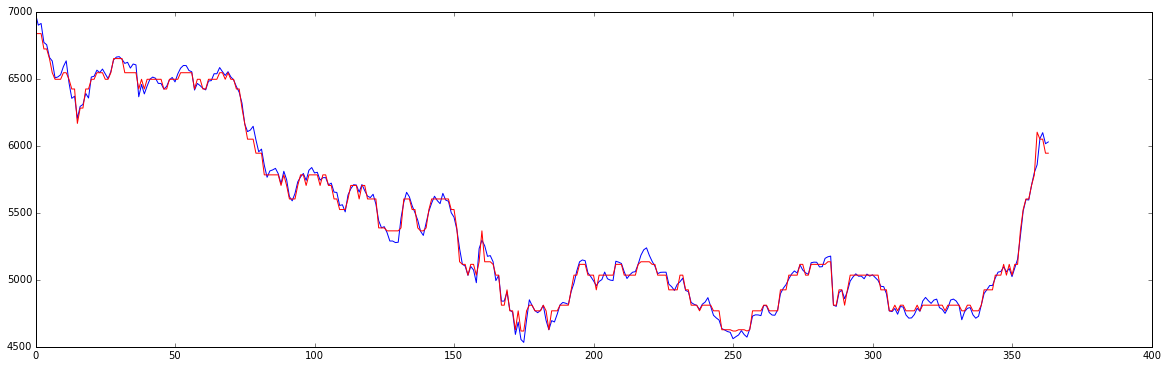

In [139]:
wfts2p = wfts2.plot(taiexsample)

# Improved Weighted Fuzzy Time Series

Os trabalhos de \cite{ismail2011enrollment} e \cite{efendi2013improved} modificam a forma como os pesos são assinalados às regras no modelo de \cite{yu2005weighted}. A diferença mais importante é que a quantidade de recorrências de cada regra é que vai determinar o seu peso, para uma regra $A_i \rightarrow A_j,A_k$, tendo $A_i \rightarrow A_j$ $n_1$ recorrências e $A_i \rightarrow A_k$ $n_2$ recorrências, o valor de cada peso será $w_k = n_k / \sum_{i=1..n} n_i$, sendo $n$ o número de regras.

## IWFTS - Código Fonte

In [126]:
class ImprovedWeightedFLRG:
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = {}
		self.count = 0.0

	def append(self,c):
		if c not in self.consequent:
			self.consequent[c] = 1.0
		else:
			self.consequent[c] = self.consequent[c] + 1.0
		self.count = self.count + 1.0

	def weights(self):
		return np.array([ self.consequent[c]/self.count for c in self.consequent.keys() ])
        
	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		for c in self.consequent.keys():
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c + "(" + str(self.consequent[c]/self.count) + ")"
		return tmp + tmp2

In [129]:
class ImprovedWeightedFTS(FTS):
	def __init__(self,name):
		super(ImprovedWeightedFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
		actual = self.fuzzy(data)
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid
		flrg = self.flrgs[actual["fuzzyset"]]
		mi = np.array([self.sets[s].centroid for s in flrg.consequent.keys()])
		return mi.dot( flrg.weights() )
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = ImprovedWeightedFLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual


## IWFTS - Experimento com o dataset Enrollments

6 1150.82921685
8 1202.91497648
10 422.250747348
12 1321.20343192
14 482.697281037


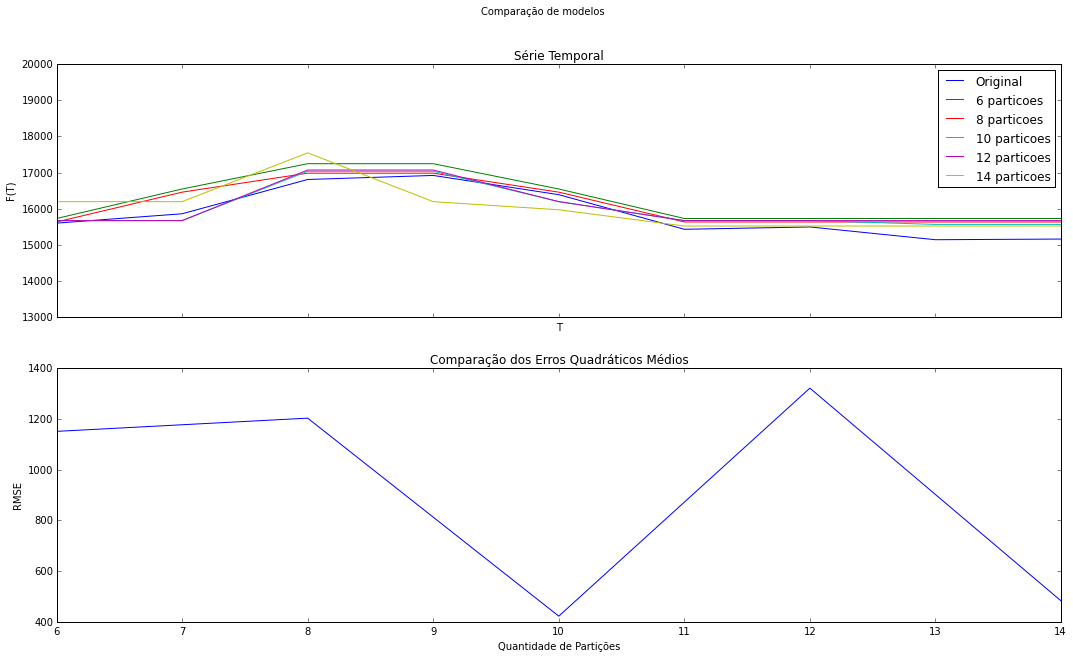

In [130]:
#fts = ImprovedWeightedFTS()
#sets = GridPartitionerTrimf(enrollments["Enrollments"],8)
#fts.learn(enrollments["Enrollments"],sets)

iwfts1 = SelecaoSimples_MenorRMSE(enrollments["Enrollments"],[6,8,10,12,14], ImprovedWeightedFTS)

In [131]:
print(iwfts1)

10 particoes:
A5 -> A4(0.5),A6(0.5)
A1 -> A1(0.5),A3(0.5)
A0 -> A1(1.0)
A9 -> A9(1.0)
A3 -> A4(0.3333333333333333),A5(0.3333333333333333),A3(0.3333333333333333)
A4 -> A4(0.6666666666666666),A6(0.16666666666666666),A3(0.16666666666666666)
A8 -> A9(1.0)
A6 -> A5(0.3333333333333333),A8(0.3333333333333333),A6(0.3333333333333333)



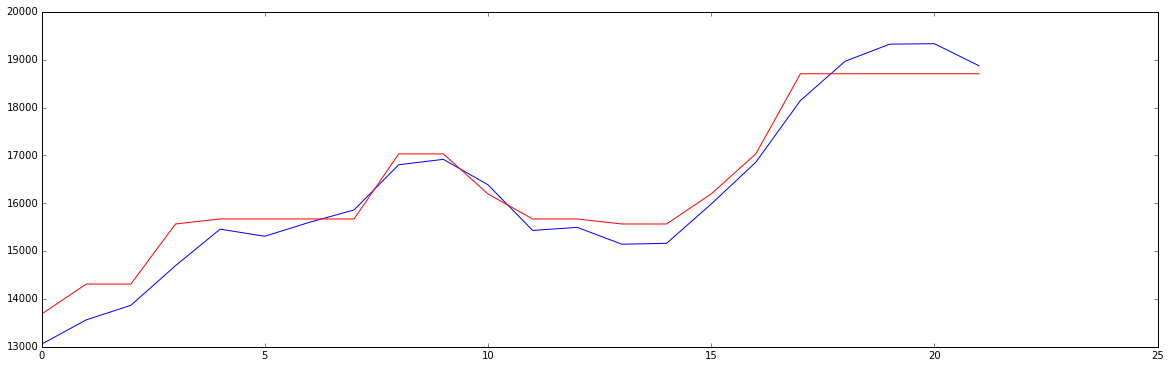

In [132]:
#np.arange(0.0,2.0)
iwfts1p = iwfts1.plot(enrollments["Enrollments"])

## IWFTS - Experimento com o dataset TAIEX

10 67.1859556092
15 119.719306981
20 38.8670347789
25 35.4696240767
30 53.3850124665
35 67.892223274


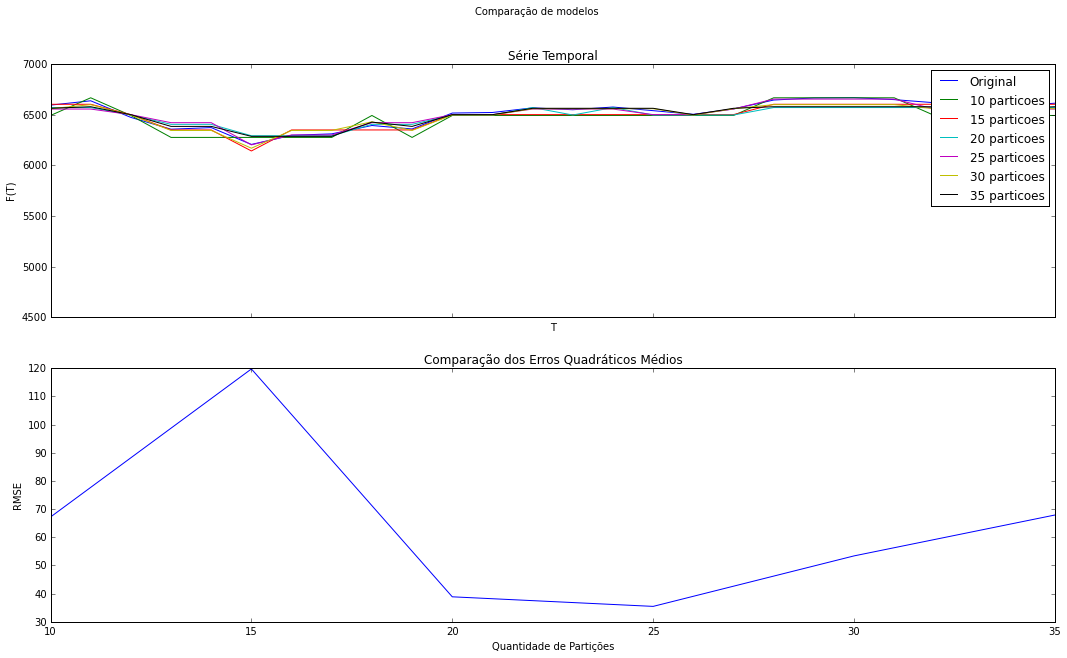

In [134]:
iwfts2 = SelecaoSimples_MenorRMSE(taiexsample,[10,15,20,25,30,35], ImprovedWeightedFTS)

In [135]:
print(iwfts2)

25 particoes:
A19 -> A19(0.38461538461538464),A17(0.07692307692307693),A20(0.46153846153846156),A18(0.07692307692307693)
A11 -> A11(0.6521739130434783),A10(0.13043478260869565),A12(0.17391304347826086),A9(0.043478260869565216)
A1 -> A1(0.5),A0(0.2),A2(0.3)
A16 -> A15(0.4),A16(0.6)
A20 -> A20(0.6071428571428571),A19(0.17857142857142858),A21(0.21428571428571427)
A13 -> A12(0.3125),A13(0.625),A14(0.0625)
A6 -> A5(0.34615384615384615),A8(0.038461538461538464),A6(0.5384615384615384),A7(0.07692307692307693)
A24 -> A24(0.6666666666666666),A23(0.3333333333333333)
A23 -> A23(0.5),A22(0.5)
A3 -> A4(0.12195121951219512),A3(0.6097560975609756),A2(0.2682926829268293)
A5 -> A5(0.6875),A4(0.08333333333333333),A6(0.1875),A7(0.020833333333333332),A3(0.020833333333333332)
A10 -> A11(0.3333333333333333),A10(0.4444444444444444),A9(0.2222222222222222)
A15 -> A15(0.75),A13(0.25)
A2 -> A4(0.02702702702702703),A1(0.08108108108108109),A0(0.02702702702702703),A2(0.5405405405405406),A3(0.32432432432432434)
A21 -

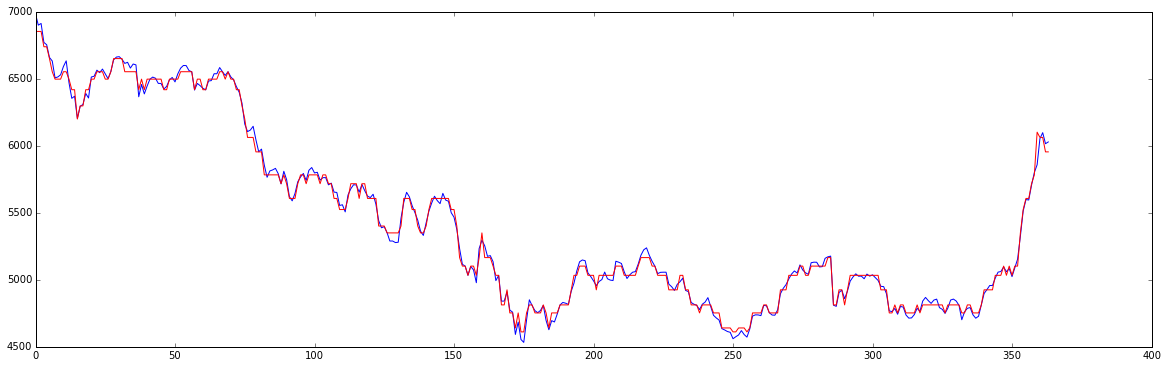

In [136]:
iwfts2p = iwfts2.plot(taiexsample)

# Exponentialy Weighted Fuzzy Time Series

O método EWFTS - \textit{Exponentialy Weighted Fuzzy Time Series}, é utilizado em \cite{sadaei2014short}, e contrasta com o crescimento linear dos pesos proposto por \cite{yu2005weighted} modificando-os por um crescimento exponencial. Dada a FLRG $A_i \rightarrow A_1,A_3,...,A_k$, a matriz $M(t) = [m_1, m_2, ...,m_k]$ dos centros de $A_1,A_3,...,A_k$ a matriz de pesos $w(t)$ será definida por um parâmetro $c$, que formará a série exponencial $c^0, c^1, ..., c^{k-1}$ normalizada. O parâmetro $c$ deve ser maior do que zero.

$$
w(t) = \left[ \frac{1}{\sum_{h=1}^k c^{h-1}},\frac{c^1}{\sum_{h=1}^k c^{h-1}},...,\frac{c^{k-1}}{\sum_{h=1}^k c^{h-1}} \right]
$$

## EWFTS - Código Fonte

In [161]:
class ExponentialyWeightedFLRG:
	def __init__(self,premiss,c):
		self.premiss = premiss
		self.consequent = []
		self.count = 0.0
		self.c = c

	def append(self,c):
		self.consequent.append(c)
		self.count = self.count + 1.0

	def weights(self):
		wei = [ self.c**k for k in np.arange(0.0,self.count,1.0)]
		tot = sum( wei )
		return np.array([ k/tot for k in wei ])
        
	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		cc = 0
		wei = [ self.c**k for k in np.arange(0.0,self.count,1.0)]
		tot = sum( wei )
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c + "(" + str(wei[cc]/tot) + ")"
			cc = cc + 1
		return tmp + tmp2

In [165]:
class ExponentialyWeightedFTS(FTS):
	def __init__(self,name):
		super(ExponentialyWeightedFTS, self).__init__(1,name)
        
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		mi = np.array([self.sets[s].centroid for s in flrg.consequent])
        
		return mi.dot( flrg.weights() )
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = ExponentialyWeightedFLRG(last["fuzzyset"],2)
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual


## EWFTS - Experimento com o dataset Enrollments

6 1605.95233851
8 1431.48680346
10 519.438292024
12 1585.33969741
14 553.604229768


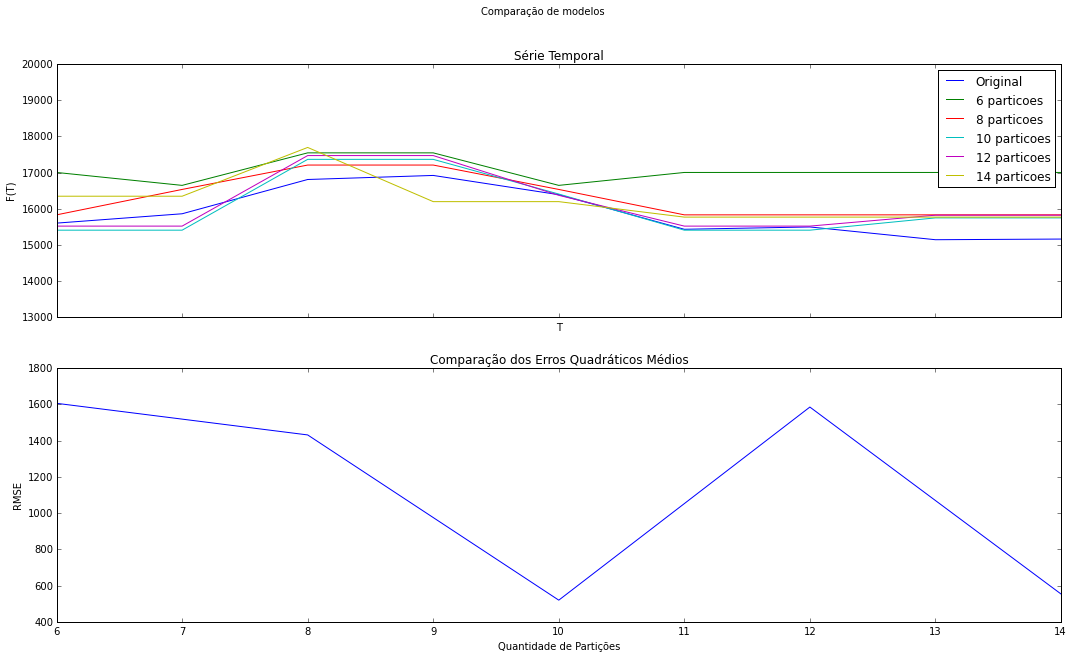

In [166]:
ewfts1 = SelecaoSimples_MenorRMSE(enrollments["Enrollments"],[6,8,10,12,14], ExponentialyWeightedFTS)

In [167]:
print(ewfts1)

10 particoes:
A5 -> A4(0.333333333333),A6(0.666666666667)
A1 -> A1(0.333333333333),A3(0.666666666667)
A0 -> A1(1.0)
A9 -> A9(0.142857142857),A9(0.285714285714),A9(0.571428571429)
A3 -> A4(0.142857142857),A3(0.285714285714),A5(0.571428571429)
A4 -> A4(0.015873015873),A4(0.031746031746),A4(0.0634920634921),A6(0.126984126984),A4(0.253968253968),A3(0.507936507937)
A8 -> A9(1.0)
A6 -> A6(0.142857142857),A5(0.285714285714),A8(0.571428571429)



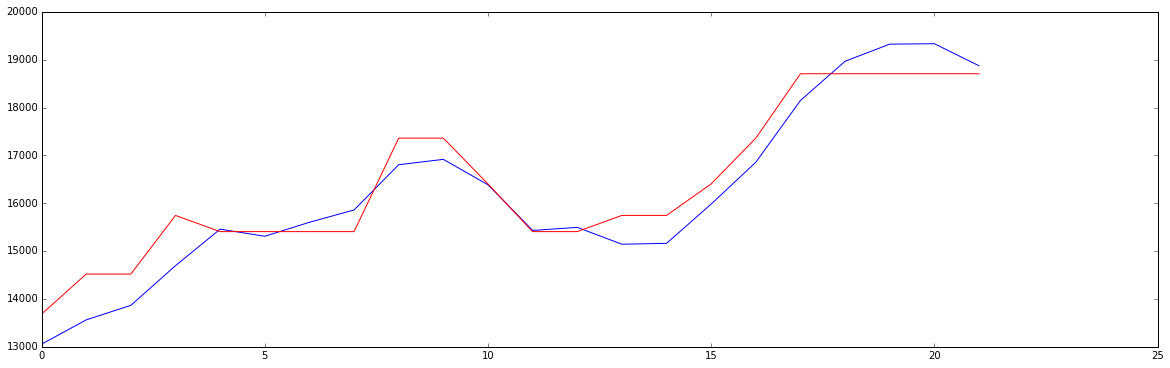

In [168]:
ewfts1p = ewfts1.plot(enrollments["Enrollments"])

## EWFTS - Experimento com o dataset TAIEX

# High Order Fuzzy Time Series

Essa implementação segue os trabalho de \cite{hwang1998handling} e \cite{chen2014high}


## HOFTS - Código Fonte


In [ ]:
class HighOrderFTS:
	def __init__(self,order):
		self.sets = {}
		self.order = order

## HOFTS - Experimento com o dataset Enrollments

## EWFTS - Experimento com o dataset TAIEX

# References

(<a id="cit-song1993fuzzy" href="#call-song1993fuzzy">Song and Chissom, 1993</a>) Song Qiang and Chissom Brad S, ``_Fuzzy time series and its models_'', Fuzzy sets and systems, vol. 54, number 3, pp. 269--277,  1993.

(<a id="cit-chen1996forecasting" href="#call-chen1996forecasting">Chen, 1996</a>) Chen Shyi-Ming, ``_Forecasting enrollments based on fuzzy time series_'', Fuzzy sets and systems, vol. 81, number 3, pp. 311--319,  1996.

(<a id="cit-hwang1998handling" href="#call-hwang1998handling">Hwang, Chen <em>et al.</em>, 1998</a>) Hwang Jeng-Ren, Chen Shyi-Ming and Lee Chia-Hoang, ``_Handling forecasting problems using fuzzy time series_'', Fuzzy sets and systems, vol. 100, number 1, pp. 217--228,  1998.

(<a id="cit-chen2014high" href="#call-chen2014high">Chen, 2014</a>) Chen Mu-Yen, ``_A high-order fuzzy time series forecasting model for internet stock trading_'', Future Generation Computer Systems, vol. 37, number , pp. 461--467,  2014.

(<a id="cit-yu2005weighted" href="#call-yu2005weighted">Yu, 2005</a>) Yu Hui-Kuang, ``_Weighted fuzzy time series models for TAIEX forecasting_'', Physica A: Statistical Mechanics and its Applications, vol. 349, number 3, pp. 609--624,  2005.

(<a id="cit-ismail2011enrollment" href="#call-ismail2011enrollment">Ismail and Efendi, 2011</a>) Ismail Zuhaimy and Efendi R, ``_Enrollment forecasting based on modified weight fuzzy time series_'', Journal of Artificial Intelligence, vol. 4, number 1, pp. 110--118,  2011.

(<a id="cit-efendi2013improved" href="#call-efendi2013improved">Efendi, Ismail <em>et al.</em>, 2013</a>) Efendi Riswan, Ismail Zuhaimy and Deris Mustafa Mat, ``_IMPROVED WEIGHT FUZZY TIME SERIES AS USED IN THE EXCHANGE RATES FORECASTING OF US DOLLAR TO RINGGIT MALAYSIA_'', International Journal of Computational Intelligence and Applications, vol. 12, number 01, pp. 1350005,  2013.

(<a id="cit-sadaei2014short" href="#call-sadaei2014short">Sadaei, Enayatifar <em>et al.</em>, 2014</a>) Sadaei Hossein Javedani, Enayatifar Rasul, Abdullah Abdul Hanan <em>et al.</em>, ``_Short-term load forecasting using a hybrid model with a refined exponentially weighted fuzzy time series and an improved harmony search_'', International Journal of Electrical Power \& Energy Systems, vol. 62, number , pp. 118--129,  2014.

